```
                            (#%(//***,.                                         
                          %@&&&&&&&&%&&&&&&#                                    
                       ,@@@@@&&%#(/*,,*(#%&&@&. ,#%&&&&&@&&#,                   
                      %&@@@@&&%(*,.....,*(#%&&@&&@@@@@&%&&@@@@@@@&              
                     /%@&@@@&%%(/******/(##%&&@@&@@&#((////(((#%&@@@@           
            /&@@@@@@&%@@@&@@&%%###(((#%%%&&&&&&&##%&#///*/(&@@@&%%&@@@#         
        (@@@@&/@@@@@@@@#%@@@@&&%%%%*/#&%#%&&&@@@@@@&#//&%                       
      @@@&&((##(%&@@@@@@&%@%@&@(%#%%%%%%,./(/.(/&((&@.                          
    &@@%//***,****(#%&@@@@@@@@%&*/#/.*(///*,//.#%%,&                            
   &@@(/**,,,,,,,,,,/&&@@@@@@@@&. ((/  /#%####%&&&(&                            
  &@@#(#%@@@&*        %@@@@@@@@&*#%&/%((((%&&%%&&@@&                            
 .@@@@@                   (#&&&&@@@@&&&//,,,(/(##/                             ,
 .@&                      %@@&&(%(,*(/,..*(#/(%#((#%(.                       ,.@
  .                   .(&%&@@@&%##**(#@/,  %@%%@#/#,%&&&                    ,.@@
                  *%&@@&(/#%&@&@@@#(.. .,,*/*&@@@///,%%&@%                 ,.@@@
                &@@@&&&%&@*,(#@@&@@@@@@(. ,&@&%@@&(,%,&&@@/              .,(@@@@
               &@@%%(/#%&@@,,*(%@%@@@@@@@&##/(%&&%&#/#&@@@&           ..*.@@@@@@
               @@@&%%%&&&@@@,%,&%&&&@@&%((&(%&@@@@%@#&&&&&@&.        ..*,@@@@@@@
               #@@@&%(((%&&@%#,(%%@@&@&%*@@@@@@@@@@@%@&&/(#&&*...  ...*,@@@@@@@@
               .%&&&(  ,(%&&@&*(&&&&&%/,&@&(@@&%&@@@&@@@&**#&&&,. ../*(@@@@@@@@&
         .......%&@@@&&&@@@@@&/&&&%%#/(&@&(%%@%%%%@&@&&@@&&./#%%* ./*&@@@@@@@@@@
##############(,*@@&&&&&&&@@@&&@@@@&#*#&&@&#%&%%#%%%@@&%@&&&#,(%&%*/@@@@@@@@@@@@
##############(*.@@@%%#&&&@@@&@&%#(*#&@&#(#&&%&&##(,%&&&%%&@&&&@%/&@@@@@@@@@@@@@
((##########(((/.%@@@#(#%&&@&&&%(*,(#%%&&(%#%#%&%#(,.#%&@@&@(,,%*#@@@@@@@@@@@@@@
//(##########(,...@@@@@&&%@@&&%#((#%&&&%&%%&%%%&&%    ##%&@@@@/*&%@@@@@@@@@@@@@@
(###########((/,,.(@@@&/,(@&&&&%%&&&&&%%&&&%%%%&&........%%%%**@@@@@@@@&@@@@@@@@
###(,,,,*/(((((*,(%@@@@@@@@&&&&&&&@&%/&&%#%%%%&&#./#(*//(((%*/@@@@@@@@@@@@@@@@@@
,*###(((((((((((#&&@@&@@@@&@@&&@@&&(&#**,**,,,********//((%*#@@@@@@@@@@@@@@@@@@@
///////////////(#%&&@@&@@@@@@@@@&(**,*,,,,,,,,,*%//%##(##(*&@@@@@@@@@@@@@@@@@@@@
///////////////////(##%&@@@@@@@&%******&/(##%###########/*@@@@@@@@@@@@@@@@@@@@@@
////////////////////((#%%%%&@@@&&#,(/#%*,*/*.&%########//@@@@@@@@@@@@@@@@@@@@@@&
%%(*/////////////////////(///////#@@@@@@@@/(%*,*/(.,&&*(@@@@@@@@@@@@@@@@@@@@@@(/
```
# Goblin Mode

In [ ]:
# This is the version of torch I am using if you happen to be on windows and have a decent GPU.
# pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [1]:
import cv2
import matplotlib.pyplot as plt
import copy
import numpy as np
import os
import requests
import json
from IPython import display
from src import model
from src import util
from src.body import Body

body_estimation = Body('model/body_pose_model.pth')

c:\Users\mckay\anaconda3\envs\pytorch-openpose\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
myPath = os.getcwd()
myYogaPath = os.path.join(myPath, 'yoga')
myYogaFolders = os.listdir(myYogaPath)

body_estimation = Body('model/body_pose_model.pth')

In [3]:
def load_chechpoint(myPath):
    goodFile = open(os.path.join(myPath, 'good.json'), 'r')
    badFile = open(os.path.join(myPath, 'bad.json'), 'r')
    goods = json.load(goodFile)
    bads = json.load(badFile)
    goodFile.close()
    badFile.close()
    return goods, bads

def save_chechpoint(goods, bads):
    good_json = json.dumps(goods, indent = 4) 
    bad_object = json.dumps(bads, indent = 4) 
    with open("good.json", "w") as good_file:
        good_file.write(good_json)
    with open("bad.json", "w") as bad_file:
        bad_file.write(bad_object)

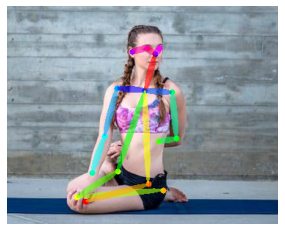

In [6]:
# This is a quick tool I made to filter out images that the pose estimator does poorly on.
# See good and bad json. 
# To use, press play, then you'll see an image with the pose estimation on top.
# If the pose estimation is good, simply press enter in the command prompt and it will be added to good.
# If the estimation is bad, enter 'k', and if you'd like to skip to the next pose category, enter 's'.
# Finally enter 's' again if you'd like to exit the tool.
# Do not just pause the notebook because your progress will not be stored in the json files.

# This is just one possible (partial) solution, by no means do I think we NEED to do this right away.

goods, bads = load_chechpoint(myPath)

for folder in myYogaFolders:

    posePath = os.path.join(myYogaPath, folder)
    myYogaImages = os.listdir(posePath)

    for image in myYogaImages:

        if image in goods[folder] or image in bads[folder]:
            continue

        test_image_url = os.path.join(posePath, image)

        oriImg = cv2.imread(test_image_url)
        candidate, subset = body_estimation(oriImg)
        oriImg = util.draw_bodypose(oriImg, candidate, subset)
        plt.imshow(oriImg[:, :, [2, 1, 0]])
        plt.axis('off')
        plt.show()

        x = input()
        if x == 's':
            display.clear_output(wait=True)
            break
        elif x == 'k':
            bads[folder].append(image)
        else:
            goods[folder].append(image)
        
        display.clear_output(wait=True)

    x = input()
    if x == 's':
        break

save_chechpoint(goods, bads)